### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [3]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [4]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


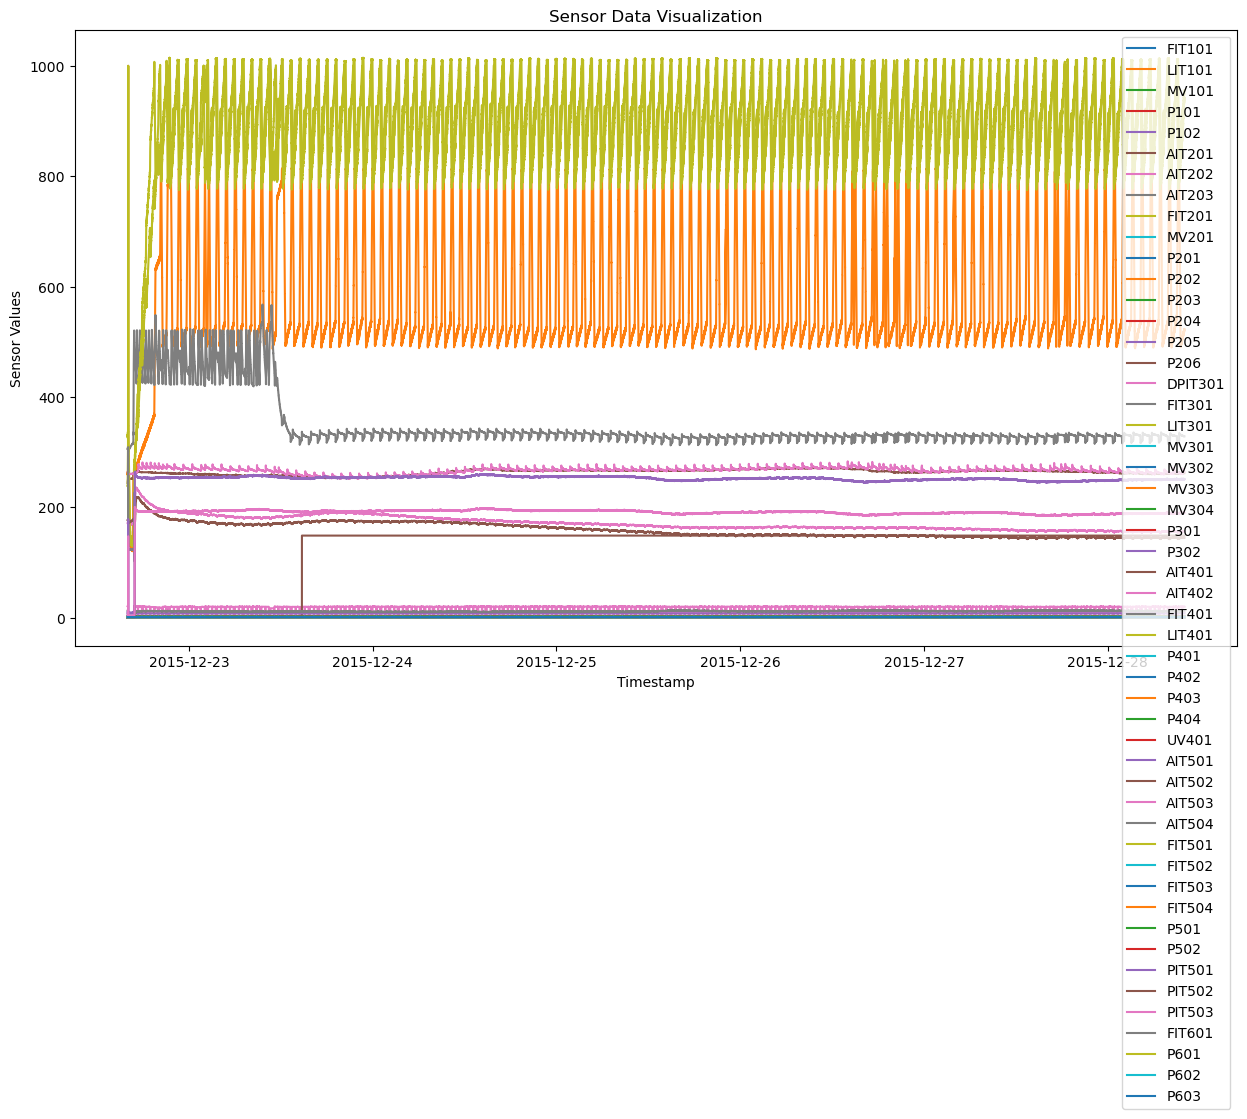

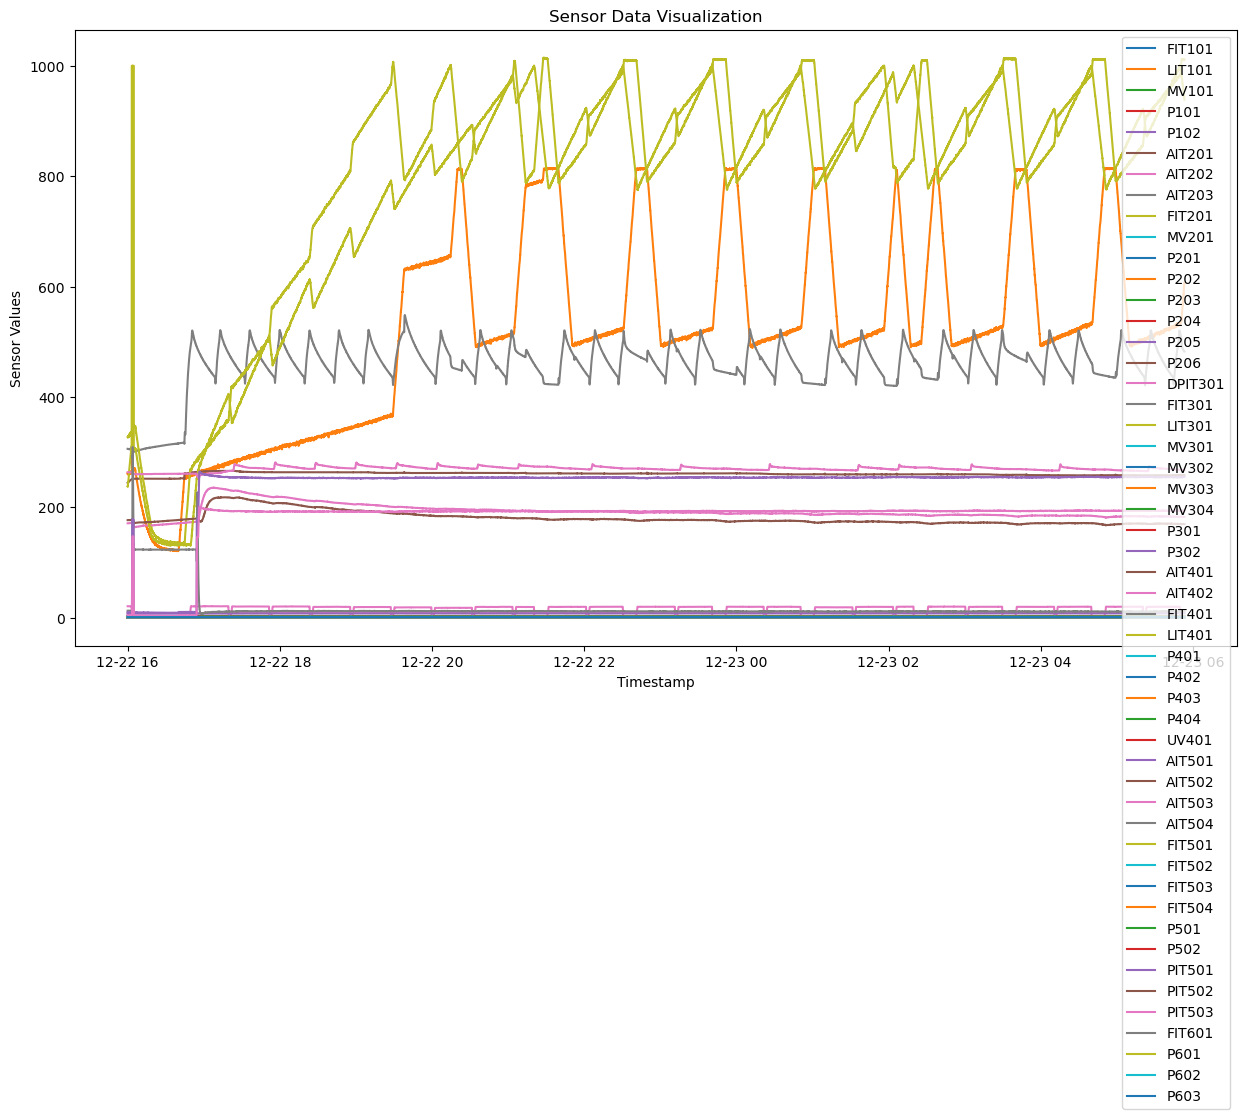

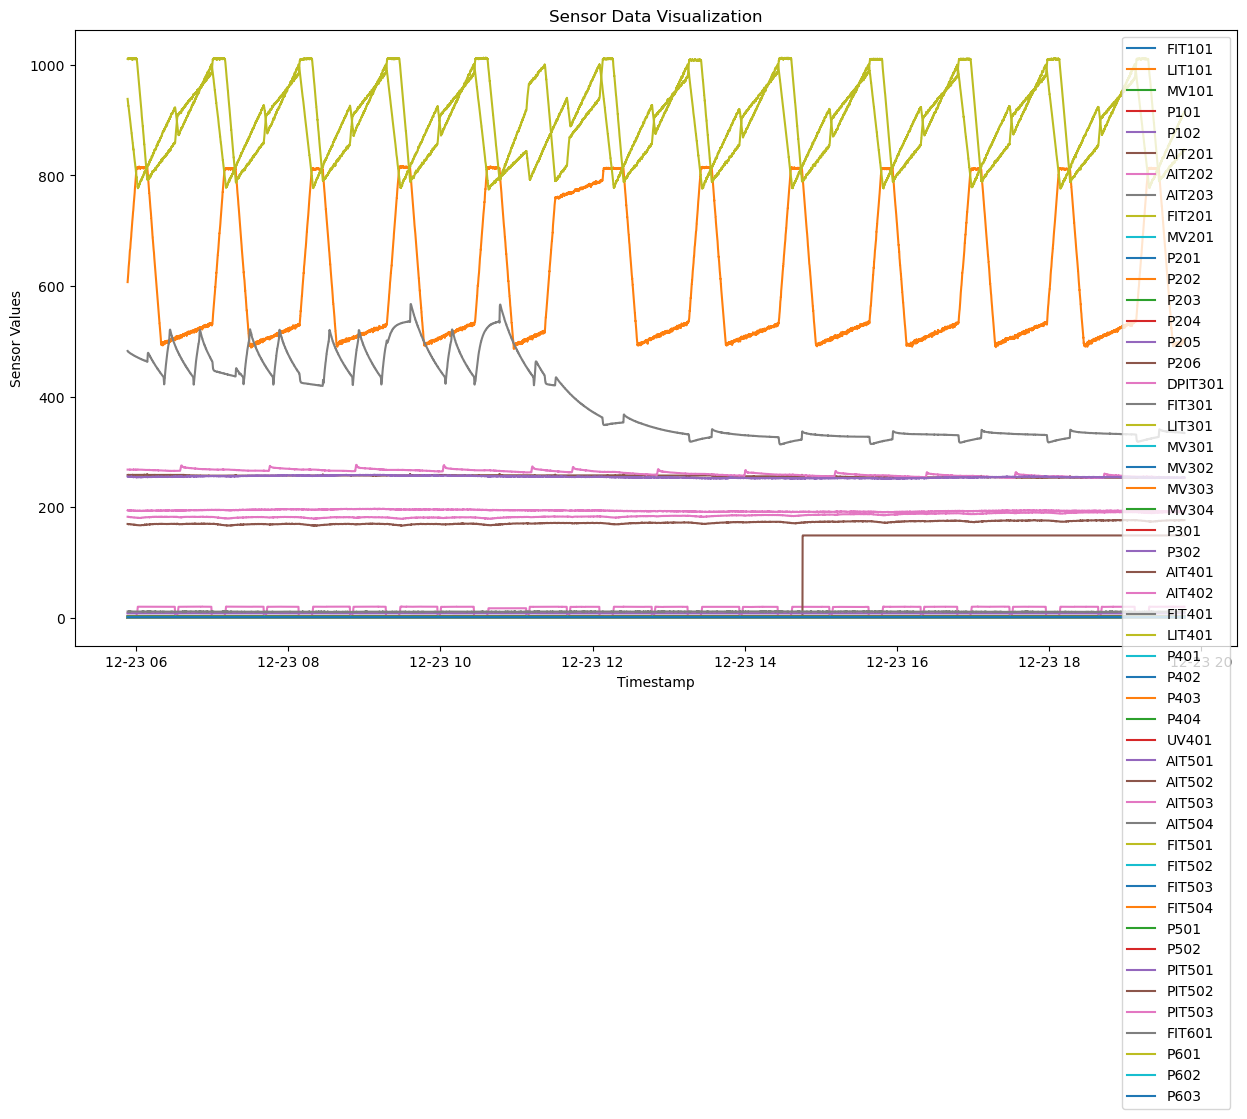

In [39]:
def visualize_sensor_data(df, window=None, sensors=None, title="Sensor Data Visualization"):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    plt.legend()

    plt.show()

# visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
# visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)
visualize_sensor_data(train_data, window=(0, 50000))
visualize_sensor_data(train_data, window=(50000, 100000))

#### Observations
After observing these plots we can group the signals into 3 categories

- Value < 50
- 50 <= Value <= 300 
- Value > 300

So the next step is to visualize these groups

In [36]:
first_col = train_data.iloc[:, 0]
norm_attack = train_data.iloc[:, -1:]
sensors = train_data.iloc[:, 1:-1]

higher_range  = sensors.loc[:, (sensors.mean() > 300 ) | (sensors.max()  > 300)]
mid_range     = sensors.loc[:, (sensors.mean() >= 50 ) & (sensors.mean() <= 300)]
lower_range   = sensors.loc[:, (sensors.mean() < 50  ) & (sensors.max()  < 300) & (sensors.mean() > 5)]
lowest_range  = sensors.loc[:, (sensors.mean() <= 5  ) ]

higher_range_data = pd.concat([first_col, higher_range, norm_attack], axis=1)
mid_range_data    = pd.concat([first_col, mid_range, norm_attack], axis=1)
lower_range_data  = pd.concat([first_col, lower_range, norm_attack], axis=1)
lowest_range_data = pd.concat([first_col, lowest_range, norm_attack], axis=1)


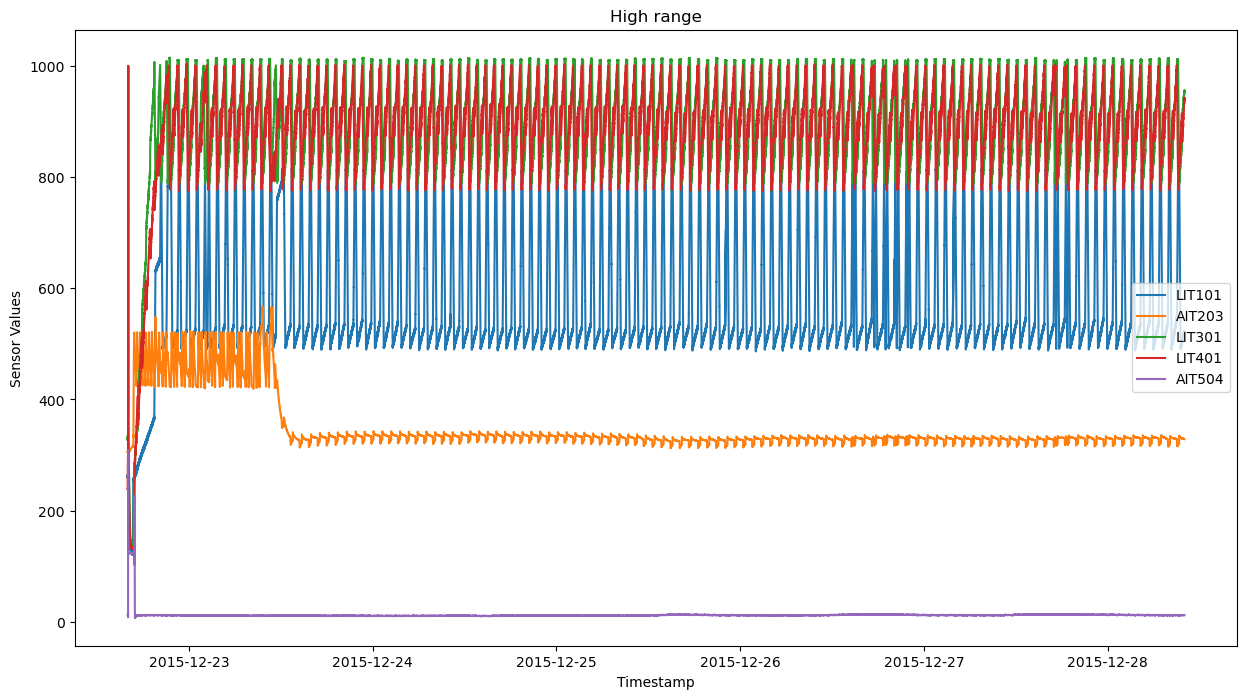

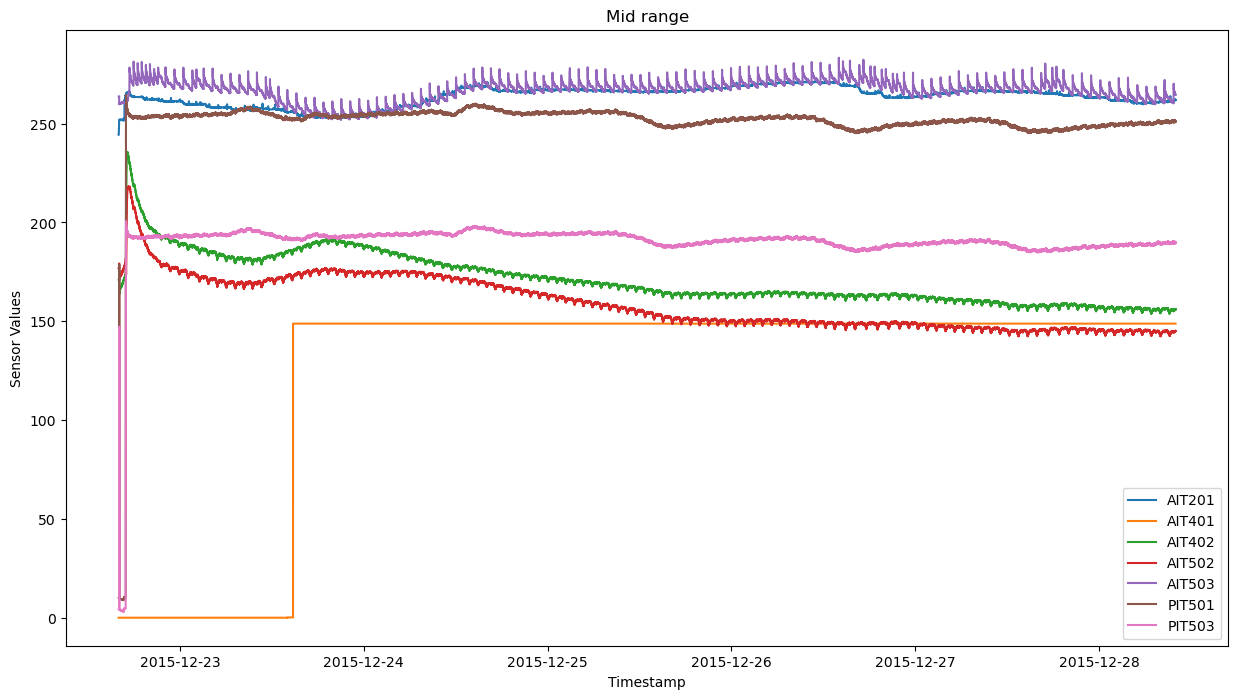

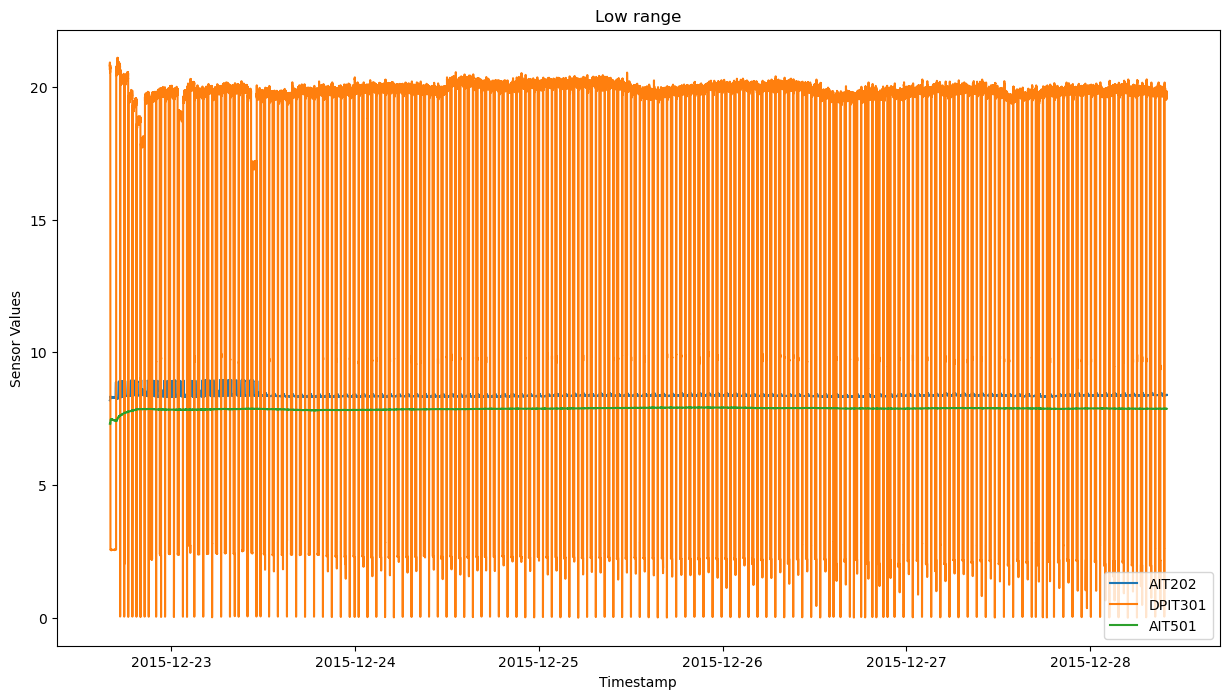

/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


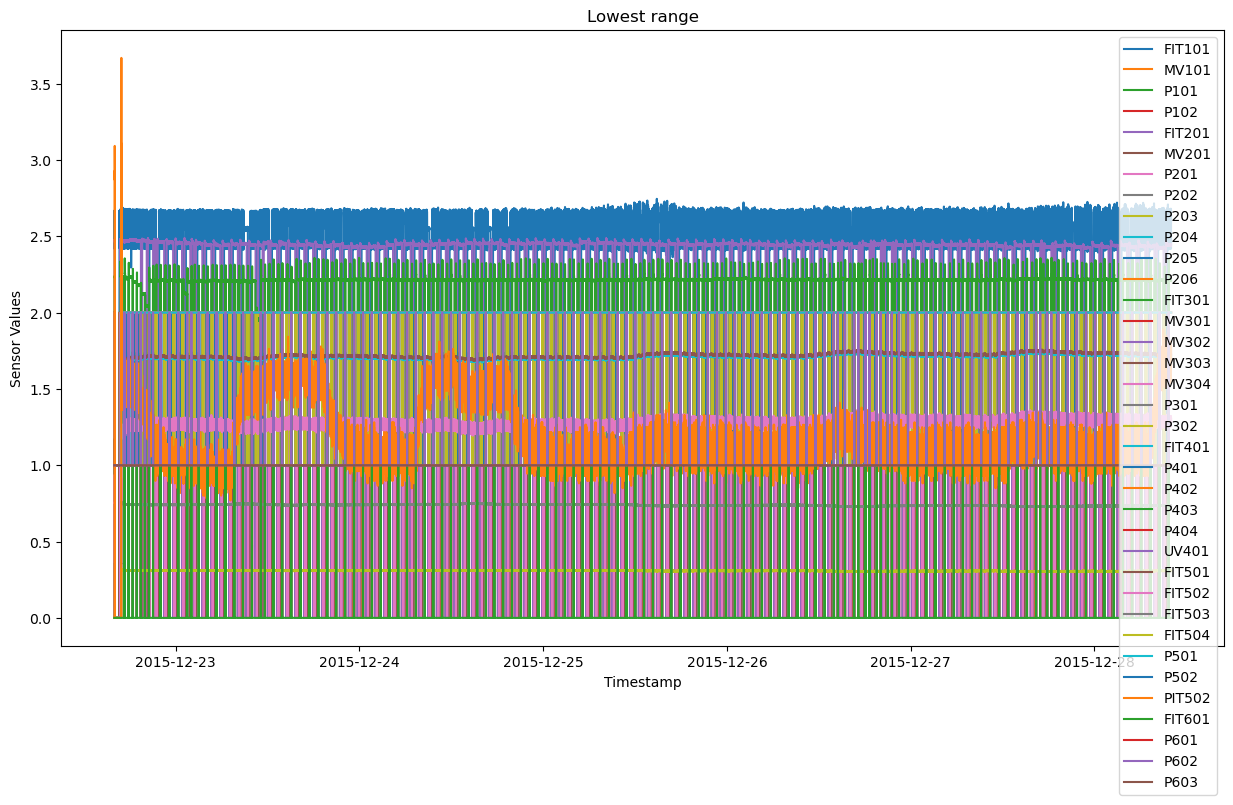

In [40]:
visualize_sensor_data(higher_range_data, title="High range")
visualize_sensor_data(mid_range_data,    title="Mid range")
visualize_sensor_data(lower_range_data,  title="Low range")
visualize_sensor_data(lowest_range_data, title="Lowest range")


Now we can see the differences between signals more clearly

Key takaways are:
- The majority of the signals are constant and periodic
- Not every signal howeever, some stay flat with ocasionally large jumps



#### What types of signals are there?

I dibided

#### Are the signals correlated? Do they show cyclic behavior?